tinymodel params: 1052673
The model:
TinyModel(
  (activation): LeakyReLU(negative_slope=0.01)
  (linear1): Linear(in_features=1, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1, bias=True)
)
x= tensor([[0.2784],
        [3.9643],
        [3.1847],
        [0.4668],
        [0.3042],
        [2.9136],
        [5.0141],
        [3.8507],
        [4.3844],
        [3.6566],
        [4.4272],
        [3.4171],
        [3.8772],
        [2.5476],
        [1.4460],
        [5.2734],
        [0.6692],
        [3.1092],
        [4.2055],
        [4.6332],
        [2.8540],
        [2.7563],
        [2.2667],
        [1.6208],
        [0.4982],
        [3.5863],
        [6.0257],
        [1.3812],
        [2.1798],
        [0.2561],
        [4.2883],
        [4.8188],
        [2.4791],
        [5.3742],
        [5.9641],
        [1.1787],
        [1.0172],
        [3.8915],
        [4.7634],


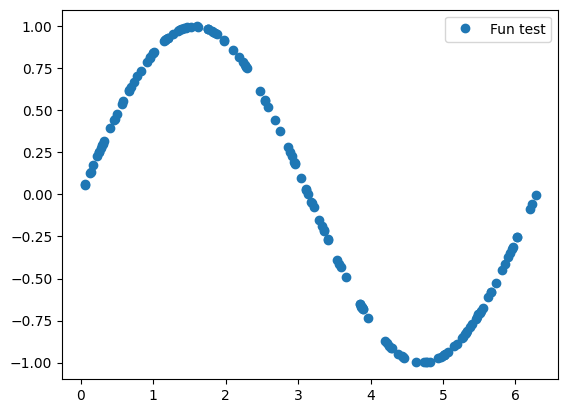

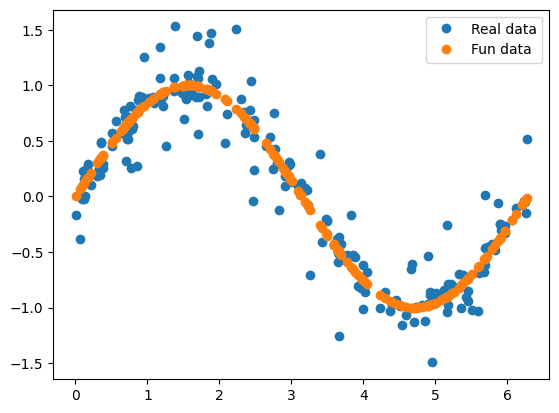

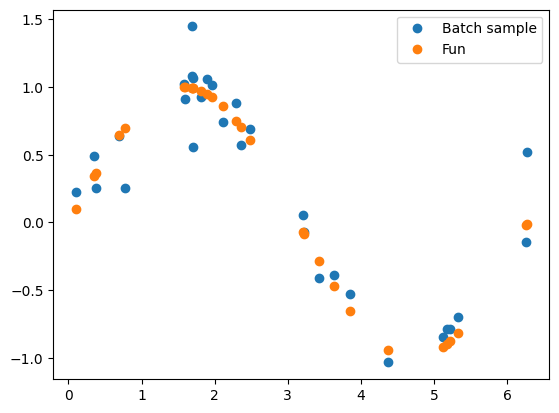

device: cuda
Train
epoch= 0 error= 102.442144, real=99.601287
epoch= 1 error= 7.202080, real=4.568867
epoch= 2 error= 5.290088, real=2.884570
epoch= 3 error= 4.454325, real=2.072807
epoch= 4 error= 3.684998, real=1.417413
epoch= 5 error= 3.295049, real=0.838828
epoch= 6 error= 2.667972, real=0.466969
epoch= 7 error= 2.538498, real=0.385998
epoch= 8 error= 2.571342, real=0.238670
epoch= 9 error= 2.565060, real=0.229718
epoch= 10 error= 2.560659, real=0.237738
epoch= 11 error= 2.422715, real=0.175647
epoch= 12 error= 2.571617, real=0.191503
epoch= 13 error= 2.526900, real=0.288995
epoch= 14 error= 2.480930, real=0.292889
epoch= 15 error= 2.494029, real=0.347099
epoch= 16 error= 2.413121, real=0.207413
epoch= 17 error= 2.230795, real=0.239956
epoch= 18 error= 2.738923, real=0.497825
epoch= 19 error= 2.464110, real=0.258479
epoch= 20 error= 2.297369, real=0.213981
epoch= 21 error= 2.269354, real=0.199483
epoch= 22 error= 2.311376, real=0.184795
epoch= 23 error= 2.484965, real=0.349527
epoc

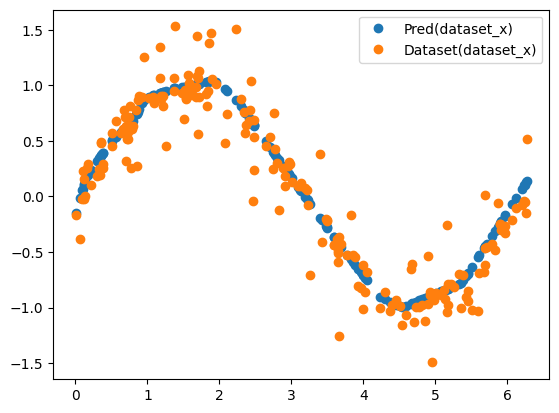

eval_random_error: 0.003935


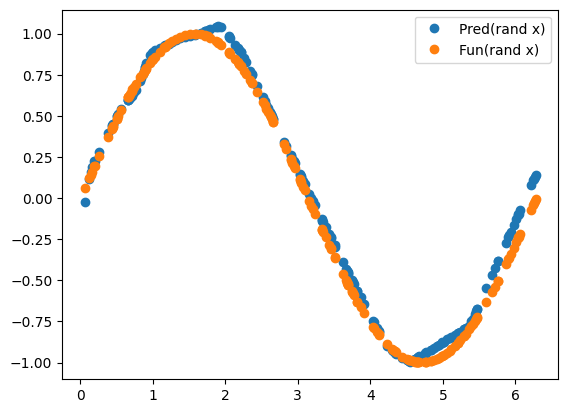

In [15]:
#%%
import torch
import matplotlib.pyplot as plt

class TinyModel(torch.nn.Module):
    def __init__(self, x=1024):
        super(TinyModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(1, x)
        self.linear2 = torch.nn.Linear(x, x)
        self.linear3 = torch.nn.Linear(x, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

if __name__ == '__main__':
    tinymodel = TinyModel()

    print("tinymodel params: %i" % sum([param.nelement() for param in tinymodel.parameters()]))

    print('The model:')
    print(tinymodel)

    def data_plot(title, x, y, y2=None):
        fig, ax = plt.subplots()
        ax.plot(x, y, 'o')
        if y2 is not None:
            ax.plot(x, y2, 'o')
        ax.legend(title)
        plt.show()

    def data_fun(batch=30, range=2 * torch.pi):
        x = torch.rand(batch, 1) * range
        return x, torch.sin(x)

    # test
    x, y = data_fun(150)
    print("x=", x)
    print("y=", y)
    data_plot(["Fun test"], x, y)

    def dataset_gen(batch=500, range=2 * torch.pi, noise=True, errors=True):
        x, y_true = data_fun(batch)
        # add noise
        y_real = y_true.clone()
        if noise:
            y_real += torch.rand(batch, 1) * 0.3 - 0.15
        # add errors
        y_real2 = y_real.clone()
        if errors:
            num = .15
            idx = (torch.rand(int(batch * num)) * batch).long()
            y_real2[idx, :] += .1 + torch.rand(int(batch * num), 1) * 0.6
            idx = (torch.rand(int(batch * num)) * batch).long()
            y_real2[idx, :] -= .1 + torch.rand(int(batch * num), 1) * 0.6
        return x, y_real2, y_true

    # dataset
    dataset = dataset_gen(200)
    data_plot(["Real data", "Fun data"], *dataset)

    def data_gen(dataset, batch=30):
        size = dataset[0].size(0)
        idx = (torch.rand(batch) * size).long()
        return dataset[0][idx], dataset[1][idx], dataset[2][idx]

    # batch sample
    data_plot(["Batch sample", "Fun"], *data_gen(dataset))

    # train block
    # %%
    # cuda
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device: %s" % device)
    tinymodel = tinymodel.to(device)

    print("Train")
    tinymodel.train()
    optimizer = torch.optim.Adam(tinymodel.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss(reduction="mean")
    for epoch in range(30):
        err = 0
        true_error = 0
        for step in range(50):
            # Every data instance is an input + label pair
            inputs, labels, ground_true = data_gen(dataset, 100)

            inputs = inputs.to(device)
            labels = labels.to(device)
            ground_true = ground_true.to(device)
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            # Make predictions for this batch
            outputs = tinymodel(inputs)
            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()
            # Model parameters optimization
            optimizer.step()

            err += loss.item()
            true_error += loss_fn(outputs, ground_true).item()
            print("\rerror = %f , real= %f" % (err, true_error), end="")
        print("\repoch= %d error= %f, real=%f" % (epoch, err, true_error))

    # eval on dataset data
    # %%
    tinymodel.eval()
    # pred on dataset
    x, y_dataset, y_true = dataset
    x = x.to(device)  # move x to the same device as the model
    y_true = y_true.to(device)  # move y_true to the same device as the model
    y_pred = tinymodel(x)
    eval_error = loss_fn(y_pred, y_true).item()
    print("eval_dataset_error: %f" % eval_error)
    data_plot(["Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)

    # eval on random data
    # %%
    tinymodel.eval()
    x, y_true = data_fun(dataset[0].size(0))
    x = x.to(device)  # move x to the same device as the model
    y_true = y_true.to(device)  # move y_true to the same device as the model
    y_pred = tinymodel(x)
    eval_error = loss_fn(y_pred, y_true).item()
    print("eval_random_error: %f" % eval_error)
    data_plot(["Pred(rand x)", "Fun(rand x)"], x.cpu(), y_pred.detach().cpu(), y_true.cpu())
# %%


Task **2**

Model Params:
Small Model: 66561 parameters
Original Model: 1052673 parameters
Large Model: 4202497 parameters


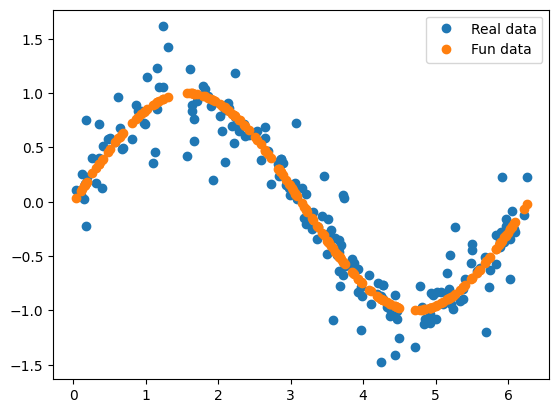

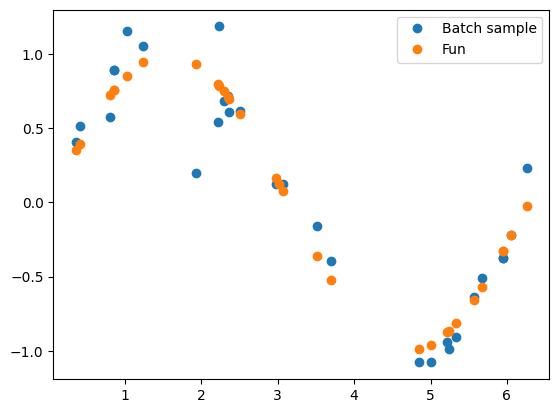


Training Small Model:
Small Model - Training complete
Small Model - Eval dataset error: 0.00608648220077157


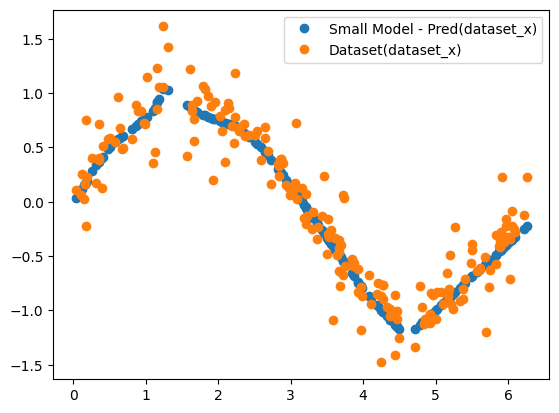


Training Original Model:
Original Model - Training complete
Original Model - Eval dataset error: 0.004983851220458746


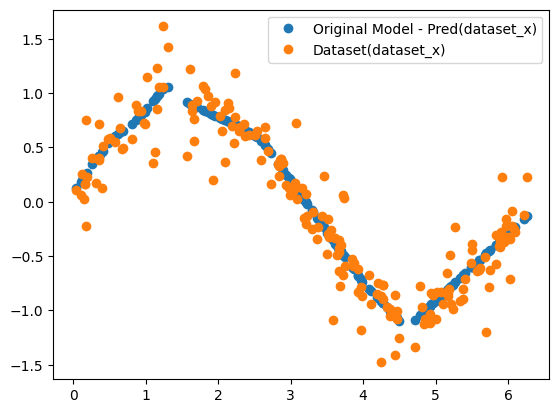


Training Large Model:
Large Model - Training complete
Large Model - Eval dataset error: 0.004985489416867495


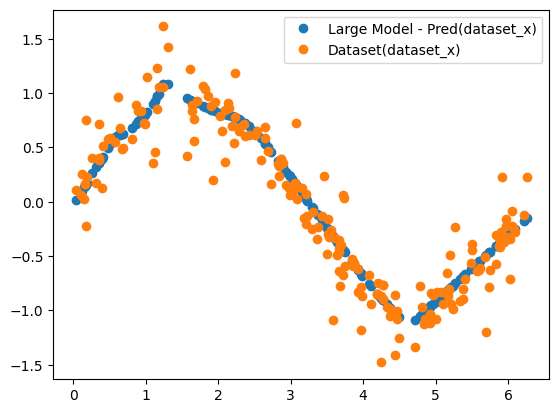

In [16]:
#%%
import torch
import matplotlib.pyplot as plt

class TinyModel(torch.nn.Module):
    def __init__(self, x=1024):
        super(TinyModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(1, x)
        self.linear2 = torch.nn.Linear(x, x)
        self.linear3 = torch.nn.Linear(x, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

if __name__ == '__main__':
    # Task 2: Changing the Number of Network Parameters
    # For a smaller model with fewer parameters
    small_model = TinyModel(x=256)

    # For the original model with 1024 parameters
    original_model = TinyModel(x=1024)

    # For a larger model with more parameters
    large_model = TinyModel(x=2048)

    models = {'Small Model': small_model, 'Original Model': original_model, 'Large Model': large_model}

    print("Model Params:")
    for name, model in models.items():
        num_params = sum([param.nelement() for param in model.parameters()])
        print(f"{name}: {num_params} parameters")

    def data_plot(title, x, y, y2=None):
        fig, ax = plt.subplots()
        ax.plot(x, y, 'o')
        if y2 is not None:
            ax.plot(x, y2, 'o')
        ax.legend(title)
        plt.show()

    def data_fun(batch=30, range=2 * torch.pi):
        x = torch.rand(batch, 1) * range
        return x, torch.sin(x)

    def dataset_gen(batch=500, range=2 * torch.pi, noise=True, errors=True):
        x, y_true = data_fun(batch)
        # add noise
        y_real = y_true.clone()
        if noise:
            y_real += torch.rand(batch, 1) * 0.3 - 0.15
        # add errors
        y_real2 = y_real.clone()
        if errors:
            num = .15
            idx = (torch.rand(int(batch * num)) * batch).long()
            y_real2[idx, :] += .1 + torch.rand(int(batch * num), 1) * 0.6
            idx = (torch.rand(int(batch * num)) * batch).long()
            y_real2[idx, :] -= .1 + torch.rand(int(batch * num), 1) * 0.6
        return x, y_real2, y_true

    dataset = dataset_gen(200)
    data_plot(["Real data", "Fun data"], *dataset)

    def data_gen(dataset, batch=30):
        size = dataset[0].size(0)
        idx = (torch.rand(batch) * size).long()
        return dataset[0][idx], dataset[1][idx], dataset[2][idx]

    data_plot(["Batch sample", "Fun"], *data_gen(dataset))

    device = "cuda" if torch.cuda.is_available() else "cpu"

    for name, model in models.items():
        model = model.to(device)

        print(f"\nTraining {name}:")
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.MSELoss(reduction="mean")
        for epoch in range(30):
            err = 0
            true_error = 0
            for step in range(50):
                inputs, labels, ground_true = data_gen(dataset, 100)
                inputs = inputs.to(device)
                labels = labels.to(device)
                ground_true = ground_true.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                err += loss.item()
                true_error += loss_fn(outputs, ground_true).item()
                print(f"\r{name} - epoch= {epoch}, error= {err}, real= {true_error}", end="")
        print(f"\r{name} - Training complete")

        model.eval()
        x, y_dataset, y_true = dataset
        x = x.to(device)
        y_true = y_true.to(device)
        y_pred = model(x)
        eval_error = loss_fn(y_pred, y_true).item()
        print(f"{name} - Eval dataset error: {eval_error}")

        data_plot([f"{name} - Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)

# %%


Task 3

Dataset Sizes:
Small Dataset: 100 samples
Original Dataset: 200 samples
Large Dataset: 500 samples

Training with Small Dataset:
Small Dataset - Training complete
Small Dataset - Eval dataset error: 0.01078068558126688


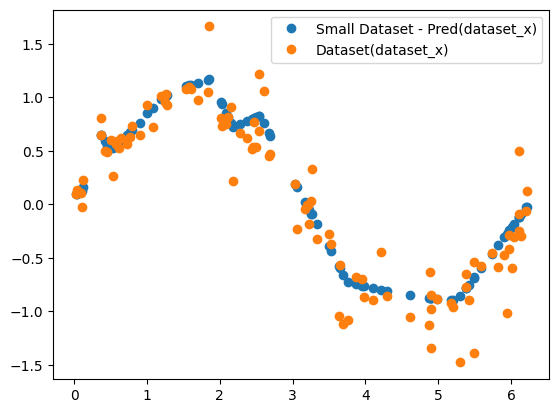


Training with Original Dataset:
Original Dataset - Training complete
Original Dataset - Eval dataset error: 0.004090150352567434


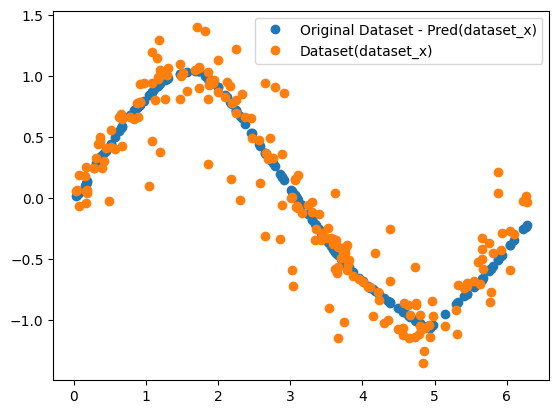


Training with Large Dataset:
Large Dataset - Training complete
Large Dataset - Eval dataset error: 0.0027204020880162716


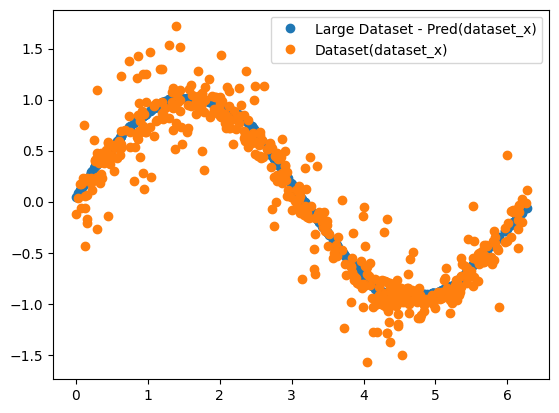

In [17]:
#%%
import torch
import matplotlib.pyplot as plt

class TinyModel(torch.nn.Module):
    def __init__(self, x=1024):
        super(TinyModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(1, x)
        self.linear2 = torch.nn.Linear(x, x)
        self.linear3 = torch.nn.Linear(x, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

if __name__ == '__main__':
    # Task 3: Changing the Size of the Entire Dataset
    # For a smaller dataset
    small_dataset = dataset_gen(batch=100)

    # For the original dataset with 200 samples
    original_dataset = dataset_gen(batch=200)

    # For a larger dataset
    large_dataset = dataset_gen(batch=500)

    datasets = {'Small Dataset': small_dataset, 'Original Dataset': original_dataset, 'Large Dataset': large_dataset}

    print("Dataset Sizes:")
    for name, dataset in datasets.items():
        dataset_size = dataset[0].size(0)
        print(f"{name}: {dataset_size} samples")

    def data_plot(title, x, y, y2=None):
        fig, ax = plt.subplots()
        ax.plot(x, y, 'o')
        if y2 is not None:
            ax.plot(x, y2, 'o')
        ax.legend(title)
        plt.show()

    device = "cuda" if torch.cuda.is_available() else "cpu"

    for name, dataset in datasets.items():
        print(f"\nTraining with {name}:")
        model = TinyModel().to(device)
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = torch.nn.MSELoss(reduction="mean")
        for epoch in range(30):
            err = 0
            true_error = 0
            for step in range(50):
                inputs, labels, ground_true = data_gen(dataset, 100)
                inputs = inputs.to(device)
                labels = labels.to(device)
                ground_true = ground_true.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                err += loss.item()
                true_error += loss_fn(outputs, ground_true).item()
                print(f"\r{name} - epoch= {epoch}, error= {err}, real= {true_error}", end="")
        print(f"\r{name} - Training complete")

        model.eval()
        x, y_dataset, y_true = dataset
        x = x.to(device)
        y_true = y_true.to(device)
        y_pred = model(x)
        eval_error = loss_fn(y_pred, y_true).item()
        print(f"{name} - Eval dataset error: {eval_error}")

        data_plot([f"{name} - Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)


Task 4


Training with batch size 20:
Small Batch Model - Training complete
Small Batch Model - Eval dataset error: 0.05061105638742447


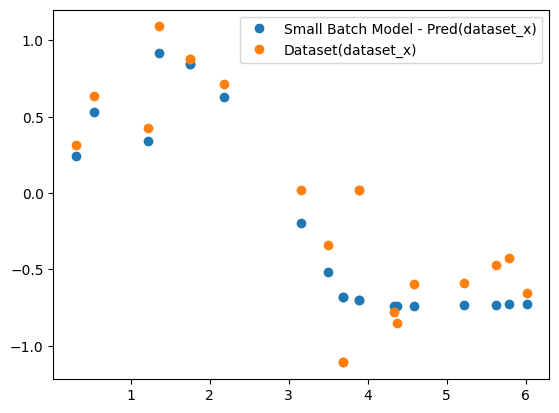


Training with batch size 30:
Original Batch Model - Training complete
Original Batch Model - Eval dataset error: 0.03908294811844826


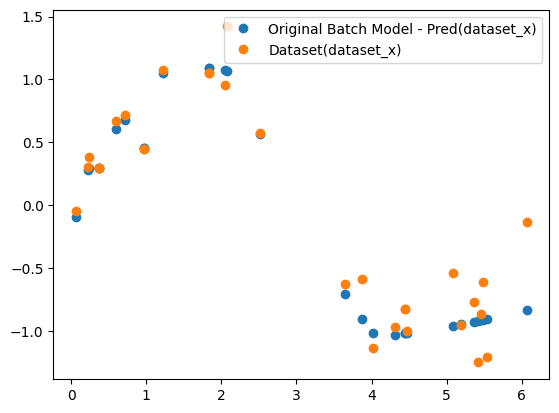


Training with batch size 50:
Large Batch Model - Training complete
Large Batch Model - Eval dataset error: 0.009284887462854385


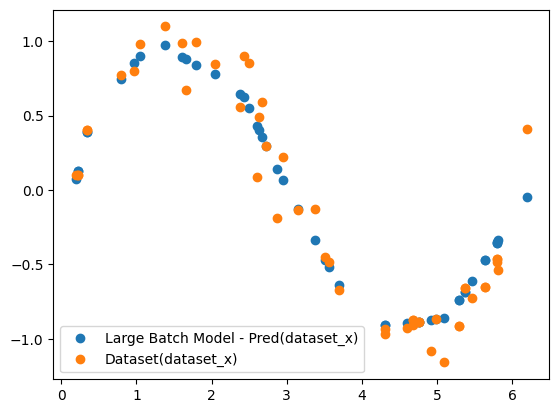

In [18]:
#%%
import torch
import matplotlib.pyplot as plt

class TinyModel(torch.nn.Module):
    def __init__(self, x=1024):
        super(TinyModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(1, x)
        self.linear2 = torch.nn.Linear(x, x)
        self.linear3 = torch.nn.Linear(x, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

def data_gen(dataset, batch=30):
    size = dataset[0].size(0)
    idx = (torch.rand(batch) * size).long()
    return dataset[0][idx], dataset[1][idx], dataset[2][idx]

def data_plot(title, x, y, y2=None):
    fig, ax = plt.subplots()
    ax.plot(x, y, 'o')
    if y2 is not None:
        ax.plot(x, y2, 'o')
    ax.legend(title)
    plt.show()

def train_and_evaluate(batch_size, dataset, model_name):
    print(f"\nTraining with batch size {batch_size}:")
    model = TinyModel().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss(reduction="mean")
    for epoch in range(30):
        err = 0
        true_error = 0
        for step in range(50):
            inputs, labels, ground_true = data_gen(dataset, batch_size)
            inputs = inputs.to(device)
            labels = labels.to(device)
            ground_true = ground_true.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            err += loss.item()
            true_error += loss_fn(outputs, ground_true).item()
            print(f"\r{model_name} - epoch= {epoch}, error= {err}, real= {true_error}", end="")
    print(f"\r{model_name} - Training complete")

    model.eval()
    x, y_dataset, y_true = dataset
    x = x.to(device)
    y_true = y_true.to(device)
    y_pred = model(x)
    eval_error = loss_fn(y_pred, y_true).item()
    print(f"{model_name} - Eval dataset error: {eval_error}")

    data_plot([f"{model_name} - Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)

if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Task 4: Changing the Batch Size
    # For a smaller batch size
    small_batch_size = 20
    small_batch = data_gen(dataset_gen(200), batch=small_batch_size)
    train_and_evaluate(small_batch_size, small_batch, "Small Batch Model")

    # For the original batch size of 30
    original_batch_size = 30
    original_batch = data_gen(dataset_gen(200), batch=original_batch_size)
    train_and_evaluate(original_batch_size, original_batch, "Original Batch Model")

    # For a larger batch size
    large_batch_size = 50
    large_batch = data_gen(dataset_gen(200), batch=large_batch_size)
    train_and_evaluate(large_batch_size, large_batch, "Large Batch Model")


Task 5


Training Original Model:
Original Model - Training complete
Original Model - Eval dataset error: 0.0061060101725161076


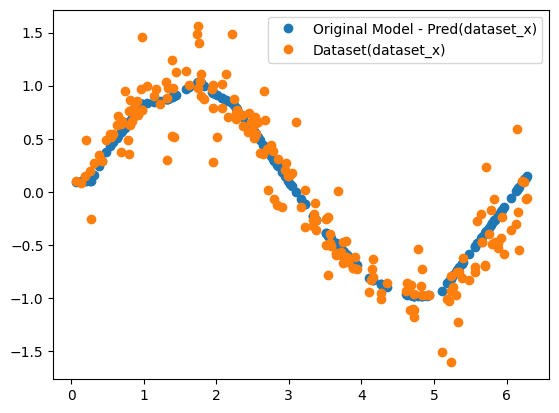


Training Modified Model:
Modified Model - Training complete
Modified Model - Eval dataset error: 0.006177309434860945


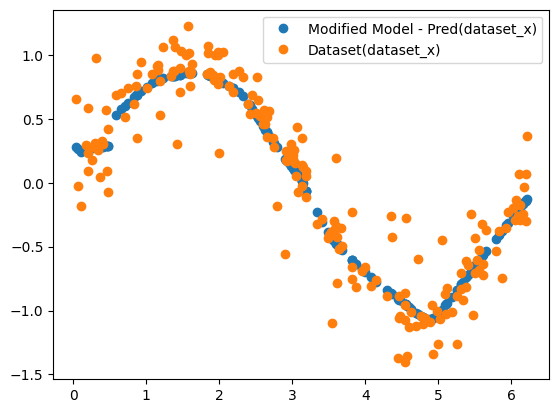

In [19]:
#%%
import torch
import matplotlib.pyplot as plt

class ModifiedModel(torch.nn.Module):
    def __init__(self, x=512):  # Reduced the number of parameters in the layers
        super(ModifiedModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.linear1 = torch.nn.Linear(1, x)
        self.linear2 = torch.nn.Linear(x, x)
        self.linear3 = torch.nn.Linear(x, x)  # Added another layer
        self.linear4 = torch.nn.Linear(x, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        return x

def train_and_evaluate_model(model, dataset, model_name):
    print(f"\nTraining {model_name}:")
    model = model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss(reduction="mean")
    for epoch in range(30):
        err = 0
        true_error = 0
        for step in range(50):
            inputs, labels, ground_true = data_gen(dataset, 100)
            inputs = inputs.to(device)
            labels = labels.to(device)
            ground_true = ground_true.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            err += loss.item()
            true_error += loss_fn(outputs, ground_true).item()
            print(f"\r{model_name} - epoch= {epoch}, error= {err}, real= {true_error}", end="")
    print(f"\r{model_name} - Training complete")

    model.eval()
    x, y_dataset, y_true = dataset
    x = x.to(device)
    y_true = y_true.to(device)
    y_pred = model(x)
    eval_error = loss_fn(y_pred, y_true).item()
    print(f"{model_name} - Eval dataset error: {eval_error}")

    data_plot([f"{model_name} - Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)

if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Task 5: Modify the model and verify the results
    original_model = TinyModel(x=1024)  # Original model
    modified_model = ModifiedModel(x=512)  # Modified model with an additional layer and reduced parameters

    models = {'Original Model': original_model, 'Modified Model': modified_model}

    for name, model in models.items():
        dataset = dataset_gen(200)
        train_and_evaluate_model(model, dataset, name)


Task 6

In [20]:
import itertools
import torch
import matplotlib.pyplot as plt

class HyperparameterTuningModel(torch.nn.Module):
    def __init__(self, x=1024, num_layers=3):
        super(HyperparameterTuningModel, self).__init__()
        self.activation = torch.nn.LeakyReLU()
        self.layers = torch.nn.ModuleList([
            torch.nn.Linear(1, x) for _ in range(num_layers)
        ])
        self.output_layer = torch.nn.Linear(x, 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        return x

def train_and_evaluate_model(model, dataset, model_name):
    print(f"\nTraining {model_name}:")
    model = model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss(reduction="mean")
    for epoch in range(30):
        err = 0
        true_error = 0
        for step in range(50):
            inputs, labels, ground_true = data_gen(dataset, 100)
            inputs = inputs.to(device)
            labels = labels.to(device)
            ground_true = ground_true.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            err += loss.item()
            true_error += loss_fn(outputs, ground_true).item()
            print(f"\r{model_name} - epoch= {epoch}, error= {err}, real= {true_error}", end="")
    print(f"\r{model_name} - Training complete")

    model.eval()
    x, y_dataset, y_true = dataset
    x = x.to(device)
    y_true = y_true.to(device)
    y_pred = model(x)
    eval_error = loss_fn(y_pred, y_true).item()
    print(f"{model_name} - Eval dataset error: {eval_error}")

    data_plot([f"{model_name} - Pred(dataset_x)", "Dataset(dataset_x)"], x.cpu(), y_pred.detach().cpu(), y_dataset)

if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Hyperparameter tuning using grid search
    learning_rates = [0.001, 0.01, 0.1]
    hidden_layer_sizes = [512, 1024, 2048]
    num_layers_values = [2, 3, 4]

    hyperparameter_combinations = list(itertools.product(learning_rates, hidden_layer_sizes, num_layers_values))

    for i, (lr, hidden_size, num_layers) in enumerate(hyperparameter_combinations):
        print(f"\nHyperparameter combination {i + 1}: Learning Rate={lr}, Hidden Layer Size={hidden_size}, Num Hidden Layers={num_layers}")

        model = HyperparameterTuningModel(x=hidden_size, num_layers=num_layers)

        dataset = dataset_gen(200)
        train_and_evaluate_model(model, dataset, f'Model_{i + 1}')



Hyperparameter combination 1: Learning Rate=0.001, Hidden Layer Size=512, Num Hidden Layers=2

Training Model_1:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x512 and 1x512)